## **方法**

### **总体架构**

图1展示了我们架构的概述。令 $\{\check{X},Y\}\underset{\mathbf{v}}{\operatorname*{\text{代表来自多模态数据集的样本}}}$，其中 $X = \{x_1, x_2, \ldots, x_m\}$ 包含 $m$ 个模态，$Y$ 是对应的标签。在我们的框架中，来自不同模态的数据首先通过模态编码器 $\{f_1, f_2, \ldots, f_m\}$ 映射到一个公共特征空间。一个由参数 $\theta$ 参数化的共享骨干 $T(\cdot;\theta)$ 用于分别处理特征，以获得每个模态的单模态表示 $h_i$。

$$h_i = T(f_i(x_i); \theta)$$

（1）

在共享骨干的末端，通过灵活的操作符 $\mathcal{F}(\cdot)$ 融合映射后的表示。对于模态不完整的情况，对应于缺失模态的隐藏状态将被丢弃。然后融合隐藏状态 $H \subseteq \{h_1, h_2, \ldots, h_m\}$。

$$H_f = \mathcal{F}(H)$$

（2）

计算最终损失函数 $\mathcal{L}(\cdot)$ 和关于共享参数 $\theta$ 的相应梯度，该梯度在融合表示和目标标签之间进行计算。

$$\mathcal{G}(H) = \nabla_\theta \mathcal{L}(\mathcal{F}(H), Y)$$

（3）

将GMD（梯度引导模态解耦）方法应用于两个不同的模态不完整表示 $H_1$ 和 $H_2$（例如，$x_1, \bar{x_2}$ 和 $\bar{x_2}, x_3$ 的梯度）的梯度，以解耦它们之间的冲突。因此，可以组合和减少共享参数的校准梯度而没有冲突。然后，将最终梯度反向传播通过共享骨干和各个模态编码器。

$$\hat{\mathcal{G}}(H_1), \hat{\mathcal{G}}(H_2) = \text{GMD}(\mathcal{G}(H_1), \mathcal{G}(H_2))$$

（4）


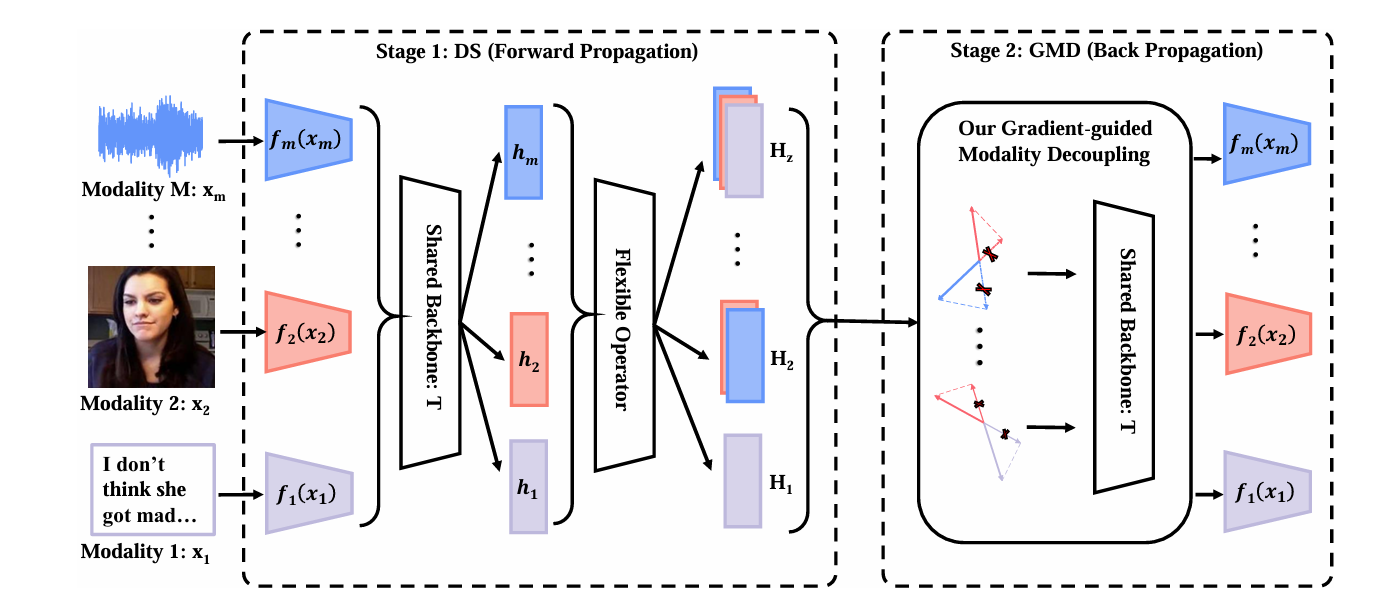

---

**图1**：包括动态共享（DS）和梯度引导模态解耦（GMD）的整体架构。多模态数据首先通过模态编码器 $\{\tilde{f}_1, f_2, \ldots, f_m\}$ 映射到一个公共特征空间。然后，这些编码器的输出被输入到一个共享架构 $T$ 中。然后，输出 $\{\bar{h}_1, h_2, \ldots, \bar{h}_m\}$ 通过一个灵活的融合操作符（例如，平均池化）来获得模态不完整表示 $\{H_1, H_2, \ldots, H_z\}$。GMD解耦冲突梯度，校准后的梯度被反向传播以减少模态优势。

---


### **缺失模态中的模态优势**

多模态模型往往由某些关键模态主导，而其他模态则未得到充分优化（Wu等人，2022）。一方面，模态优势导致单模态的未优化，例如，RFNet（Ding，Yu和Yang，2021）的T1在表1中的表现比基线差。另一方面，模态优势抑制了多模态设置中模态的能力。如表1所示，像ACN和SMU-Net这样的方法在使用多个模态时表现比使用单个模态时差，表明对特定模态的过度依赖。这两种情况都对缺失模态的鲁棒性产生重大影响。解耦多模态模型对主导模态的依赖是解决缺失模态问题的关键。



### **梯度引导模态解耦**

如上所述，模态在训练期间是耦合的，导致模态未优化。在多模态学习的背景下，由于模态的联合优化，确定模态优势的程度可能具有挑战性。当面临缺失模态时，一种常见的策略是通过使用模态不完整的输入（即在训练期间丢弃一些模态）来提高多模态模型的鲁棒性。类似地，我们提出使用模态不完整的输入来探索各种模态的耦合。

**模态不完整梯度分量** 当使用模态不完整的子集 $C_j$ 优化多模态框架时，即某些模态缺失时，相应的梯度 $\mathcal{G}(C_j)$ 可以被视为梯度空间中的模态不完整分量。特别是，当仅呈现一个模态 $x_m$ 时，$\mathcal{G}(\{x_m\})$ 被视为模态 $x_m$ 的单模态梯度分量。这使我们能够有效地分析多模态交互，并深入了解模态在学习过程中的作用。例如，通过比较 $\mathcal{G}(\{x_1\})$ 和 $\mathcal{G}(\{x_2, x_3, \ldots, x_m\})$，我们可以研究模态 $x_1$ 与其他模态 $\{x_2, x_3, \ldots, x_m\}$ 之间的优势和冲突。随着我们研究模态不完整梯度分量，我们发现模态优势问题可以通过“梯度冲突”来解释。为了表示简洁，我们让 $\mathcal{G}_j$ 表示模态不完整情况 $C_j$ 的梯度分量。

**梯度冲突** 如图2（a）所示，通过将组合梯度投影到每个模态不完整梯度分量的方向上，我们发现不同方向上的更新效果可能非常不平衡，并且偏向于更强的情况。为了量化这种梯度冲突，我们首先计算两个梯度 $\mathcal{G}_j$ 和 $\mathcal{G}_k$ 之间的余弦相似性。如果 $\mathcal{S}_{jk}$ 为正，则 $\mathcal{G}_j$ 和 $\mathcal{G}_k$ 共享一个共同的优化方向，并且两个缺失模态情况都可以在没有梯度冲突的情况下得到良好优化。否则，负的 $S_{jk}$ 表示 $\mathcal{G}_j$ 和 $\mathcal{G}_k$ 之间存在显著的方向差异（即梯度冲突）。优化有被误导的风险，导致次优优化。

$$\mathcal{S}_{jk} = \frac{\mathcal{G}_j \cdot \mathcal{G}_k}{\|\mathcal{G}_j\| \|\mathcal{G}_k\|}$$

（5）

**梯度冲突导致模态优势** 梯度冲突表明，在使用模态不完整情况进行训练时，不同的模态彼此耦合，导致性能下降。特别是，如果存在一个模态不完整输入，其梯度范数较大，它将主导优化过程。

$$\begin{aligned}
\|\mathcal{P}_{\mathcal{G}_k}^{\mathcal{G}_j}\| &= \frac{\|\mathcal{G}_k \cdot \mathcal{G}_j\|}{\|\mathcal{G}_k\|} \\
&= \|\mathcal{S}_{jk}\| \|\mathcal{G}_j\| \gg \|\mathcal{G}_k\|
\end{aligned}$$

（6）

我们从理论上验证，一个具有显著范数的梯度主导最终梯度 $\mathcal{G}_{reduced}$。在假设 $S_{jk} < 0$ 和 $\|\mathcal{G}_j\| \gg \|\mathcal{G}_k\|$（如图3所示的常见现象）的情况下，$\mathcal{G}_j$ 在 $\mathcal{G}_k$ 的法平面上的投影满足：因此，在普通优化过程中，$S_j$ 和 $S_k$ 之间的最终减少梯度变为：

$$\begin{aligned}
\mathcal{G}_{reduced} &= \mathcal{G}_j + \mathcal{G}_k \\
&= (\mathcal{G}_j - \mathcal{P}_{\mathcal{G}_k}^{\mathcal{G}_j}) + (\mathcal{P}_{\mathcal{G}_k}^{\mathcal{G}_j} + \mathcal{G}_k) \\
&\approx (\mathcal{G}_j - \mathcal{P}_{\mathcal{G}_k}^{\mathcal{G}_j}) + \mathcal{P}_{\mathcal{G}_k}^{\mathcal{G}_j} \\
&= \mathcal{G}_j
\end{aligned}$$

（7）

因此，最终优化过程的减少梯度有被 $\mathcal{G}_j$ 主导的风险，导致模态之间的耦合。

**解决方案** 为了减少由冲突梯度引起的模态优势，我们提出了一种梯度引导模态解耦（GMD）方法，在梯度冲突发生时改变梯度并消除冲突分量。具体而言，当余弦相似性 $\mathcal{S}_{jk}$ 为负时，我们从 $\mathcal{G}_k$ 中移除 $\mathcal{G}_j$ 上的投影，表示为 $\mathcal{P}_{\mathcal{G}_j}^{\mathcal{G}_k}$，只保留与 $\mathcal{G}_j$ 正交的分量。对 $\mathcal{G}_j$ 应用相同的过程。

$$\tilde{\mathcal{G}}_j = \mathcal{G}_j - \mathcal{P}_{\mathcal{G}_k}^{\mathcal{G}_j}, \quad \tilde{\mathcal{G}}_k = \mathcal{G}_k - \mathcal{P}_{\mathcal{G}_j}^{\mathcal{G}_k}$$

（8）

这基本上涉及消除模态之间的竞争梯度分量，减少了不同模态不完整情况的梯度之间的有害干扰。如图2（c）所示，现在可以更有效地组合校正后的梯度而没有负面相互作用。为了扩展到具有两个以上缺失模态情况的多模态框架，我们对任何一对具有冲突分量的情况（即负余弦相似性）执行相同的过程。我们的解冲突过程可以被视为自适应地调整冲突梯度上的权重，防止一个主导另一个。

$$\tilde{\mathcal{G}} = \left(1 - \frac{\mathcal{G}_k \cdot \mathcal{G}_j}{\|\mathcal{G}_j\|^2}\right)\mathcal{G}_j + \left(1 - \frac{\mathcal{G}_k \cdot \mathcal{G}_j}{\|\mathcal{G}_k\|^2}\right)\mathcal{G}_k$$

（9）

如图2（c）所示，减少后的梯度 $\tilde{\mathcal{G}}$ 在 $\mathcal{G}_j$ 和 $\mathcal{G}_k$ 的原始平面上具有相似的范数。因此，缺失模态情况 $S_j$ 和 $S_k$ 都可以在没有偏见的情况下得到有效更新。如图3所示，GMD调整梯度并减少大多数梯度之间的夹角，使其在 $90^\circ$ 以内，从而有效地解决了梯度冲突并缓解了模态优势问题。


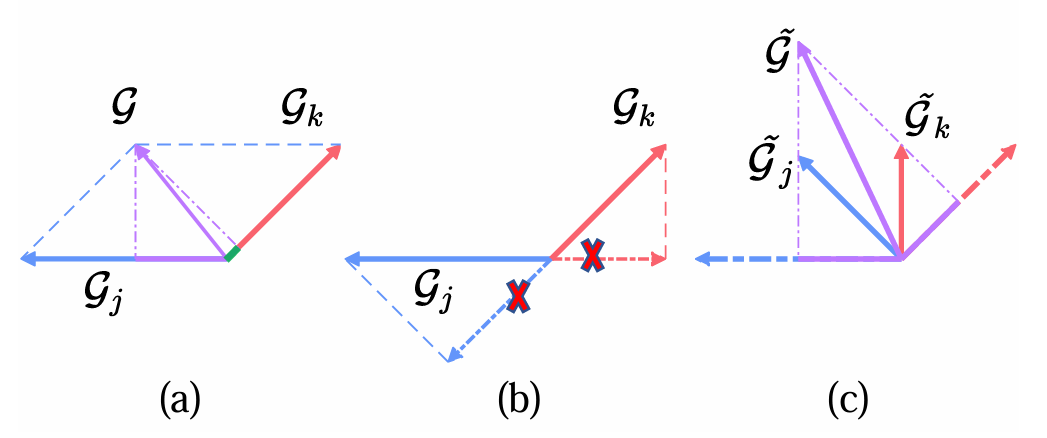

---

**图2**：（a）展示了一个梯度主导另一个梯度的情况。组合梯度 $\mathcal{G}$ 在 $\mathcal{G}_k$ 的方向上只有一个很小的投影分量，用绿色突出显示；（b）显示了要移除的冲突分量，标记为 $x$；（c）可视化了校准后的梯度。校正后的梯度现在具有相似的规模和方向。在优化过程中，两个模态不完整情况都可以有效地更新而没有冲突。

---

### **动态共享（DS）**

现有的多模态模型（Wang等人，2021；Azad，Khosravi和Merhof，2021）在产生最终预测之前融合不同模态的特征或输入数据。融合操作符，如连接，需要通过掩码值（Dorent等人，2019）或重构值（Zhou等人，2021b，a）来完成模态不完整的输入，这可能会向融合操作符引入噪声，导致模型的意外行为。

基于上述观察，我们提出了动态共享（DS）框架，如图1所示。该框架包含三个主要组件：模态特定编码器、共享骨干和特征融合机制。每个模态，由 $X_m$ 表示，最初由其模态特定编码器 $f_{\theta_m}$ 处理为一个隐藏表示 $H_m \in \mathbb{R}^h$，维度为 $h$。然后，$H_m$ 分别输入到共享骨干 $f_{\theta_s}$ 中，以获得模态特定特征 $O_m$。最后，通过一个灵活的特征融合操作符（独立于输入数量），如平均池化，将不同的模态特定特征组合起来，产生最终表示。借助模态特定组件和灵活的特征融合，我们可以自适应地处理模态不完整的数据，而不受损坏模态的影响。模态之间的互补信息可以通过共享参数隐式地利用（Chang等人，2019）。

#### **GMD与DS的关系**

GMD与DS框架的结合在整个网络优化过程中提供了一个全面的解决方案。具体而言，DS和GMD分别针对前向和后向传递中的缺失模态问题。DS允许仅传播可用模态的干净信息，避免在模态缺失时产生误导性融合。这防止了“损坏”梯度的计算。同时，GMD在反向传播中起到安全网的作用，提供了一种强大的解耦机制来解决梯度中的冲突。结果是DS和GMD之间的和谐相互作用。这种在网络训练过程的输入和输出处的联合努力使DS和GMD能够有效地提高缺失模态的鲁棒性。

### **复杂度分析**

如上所述，所提出的GMD方法利用缺失模态情况进行训练，以解决模态优势问题。当在每个迭代中考虑所有模态不完整情况时，对于具有M个模态的数据集，需要融合 $O(2^M)$ 种模态组合。为了提高效率，我们在每个训练迭代中采样一个大小为 $\bar{k}$ 的组合子集，而不是融合所有可能的模态组合。$k$ 被设置为平衡效率和覆盖率（例如，$k=5$）。这允许使用更少的融合表示和反向梯度计算来近似GMD。我们的实验表明，将GMD组合从 $O(2^m)$ 减少到 $O(km)$ 大大改善了可扩展性。此外，近似GMD实现了与完整版本相似的性能，证明了其有效性。



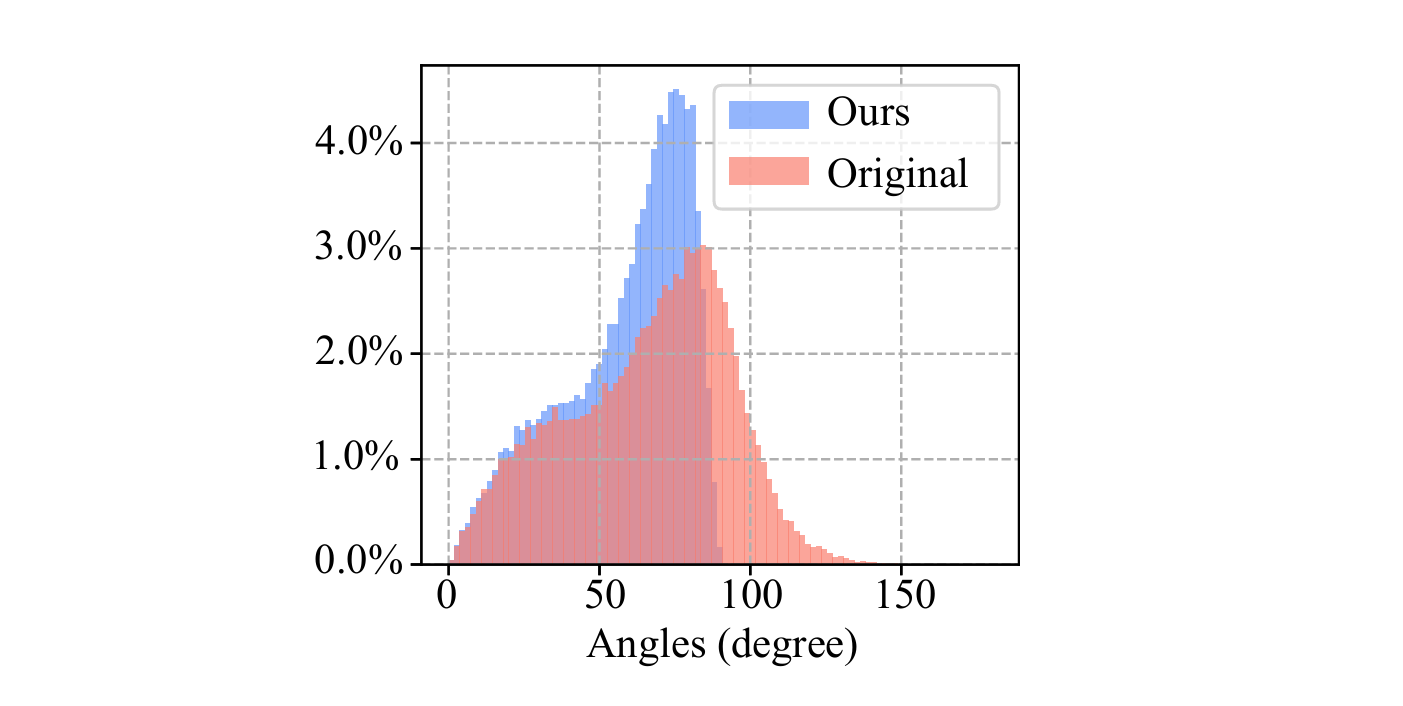

---

**图3**：模态的梯度在范数上差异显著（标准差：$4 \times 10^4$）。先前的工作忽略了梯度冲突，导致偏向于主导梯度（红色）。我们的GMD方法通过移除冲突梯度并减少角度差异，实现了更平衡的优化（蓝色）。

---